- **Name**: Borrower name
- **City**: Borrower city
- **State**: Borrower state
- **Zip**: Borrower zip code
- **Bank**: Bank name
- **BankState**: Bank state
- **NAICS**: North American industry classification system code
- **ApprovalDate**: Date SBA commitment issued
- **ApprovalFY**: Fiscal year of commitment
- **Term**: Loan term in months
- **NoEmp**: Number of business employees
- **NewExist**: 1 = Existing business, 2 = New business
- **CreateJob**: Number of jobs created
- **RetainedJob**: Number of jobs retained
- **FranchiseCode**: Franchise code, (00000 or 00001) = No franchise
- **UrbanRural**: 1 = Urban, 2 = rural, 0 = undefined
- **RevLineCr**: Revolving line of credit: Y = Yes, N = No
- **LowDoc**: LowDoc Loan Program: Y = Yes, N = No
- **DisbursementDate**: Disbursement date
- **DisbursementGross**: Amount disbursed
- **BalanceGross**: Gross amount outstanding
- **GrAppv**: Gross amount of loan approved by bank
- **SBA_Appv**: SBA’s guaranteed amount of approved loan

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

## Data Analyzation
---

In [2]:
# read the data
data = pd.read_csv("Xtrain.csv", index_col = 0)
labl = pd.read_csv("Ytrain.csv", index_col = 0)
test = pd.read_csv("Xtest.csv",  index_col = 0)
data["Outcome"] = labl
pd.set_option('display.max_columns', None)
data.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Outcome
Id,,,,,,,,,,,,,,,,,,,,,,,,
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,16-Apr-10,2010,130,25,1.0,2,0,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00",0
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,30-Jan-10,2010,33,6,1.0,1,3,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00",1
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,29-Jul-02,2002,60,1,1.0,1,1,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00",0
3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,160,1,2.0,0,0,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00",0
4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,6-Feb-06,2006,101,2,1.0,7,2,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               49999 non-null  object 
 1   City               50000 non-null  object 
 2   State              50000 non-null  object 
 3   Zip                50000 non-null  int64  
 4   Bank               49924 non-null  object 
 5   BankState          49923 non-null  object 
 6   NAICS              50000 non-null  int64  
 7   ApprovalDate       50000 non-null  object 
 8   ApprovalFY         50000 non-null  object 
 9   Term               50000 non-null  int64  
 10  NoEmp              50000 non-null  int64  
 11  NewExist           49993 non-null  float64
 12  CreateJob          50000 non-null  int64  
 13  RetainedJob        50000 non-null  int64  
 14  FranchiseCode      50000 non-null  int64  
 15  UrbanRural         50000 non-null  int64  
 16  RevLineCr          498

In [4]:
print ("Unique Values in each columns")
for k in data.columns:
    print("{:20} {}".format(k, len(data[k].unique())))

Unique Values in each columns
Name                 48757
City                 9488
State                51
Zip                  13794
Bank                 2784
BankState            53
NAICS                1118
ApprovalDate         6934
ApprovalFY           47
Term                 325
NoEmp                207
NewExist             4
CreateJob            98
RetainedJob          144
FranchiseCode        849
UrbanRural           3
RevLineCr            5
LowDoc               8
DisbursementDate     2434
DisbursementGross    14120
BalanceGross         1
GrAppv               3951
SBA_Appv             6048
Outcome              2


### NAICS

In [5]:
# preprocessing
# https://www.sba.gov/sites/default/files/files/Size_Standards_Table.pdf
def def_code(code):
    if code <= 0: return str(0)
    if code >  0: return str(code // 10000)
    
def def_rate(code): 
    sector_default = {"11": 0.09, "21" :0.08, "22": 0.14, "23": 0.23, 
               "31": 0.19, "32": 0.16, "33": 0.14, "42": 0.19, 
               "44": 0.22, "45": 0.23, "48": 0.27, "49": 0.23, 
               "51": 0.25, "52": 0.28, "53": 0.29, "54": 0.19,
               "55": 0.10, "56": 0.24, "61": 0.24, "62": 0.10, 
               "71": 0.21, "72": 0.22, "81": 0.20, "92": 0.15}

    if code in sector_default:
        return sector_default[code]
    return np.nan

data["NAICS"]       = data["NAICS"].apply(def_code)
data["NAICS_sector_rate"] = data.NAICS.apply(def_rate)
data["NAICS"]       = data["NAICS"].astype(int)
data.head()

test["NAICS"]       = test["NAICS"].apply(def_code)
test["NAICS_sector_rate"] = test.NAICS.apply(def_rate)
test["NAICS"]       = test["NAICS"].astype(int)

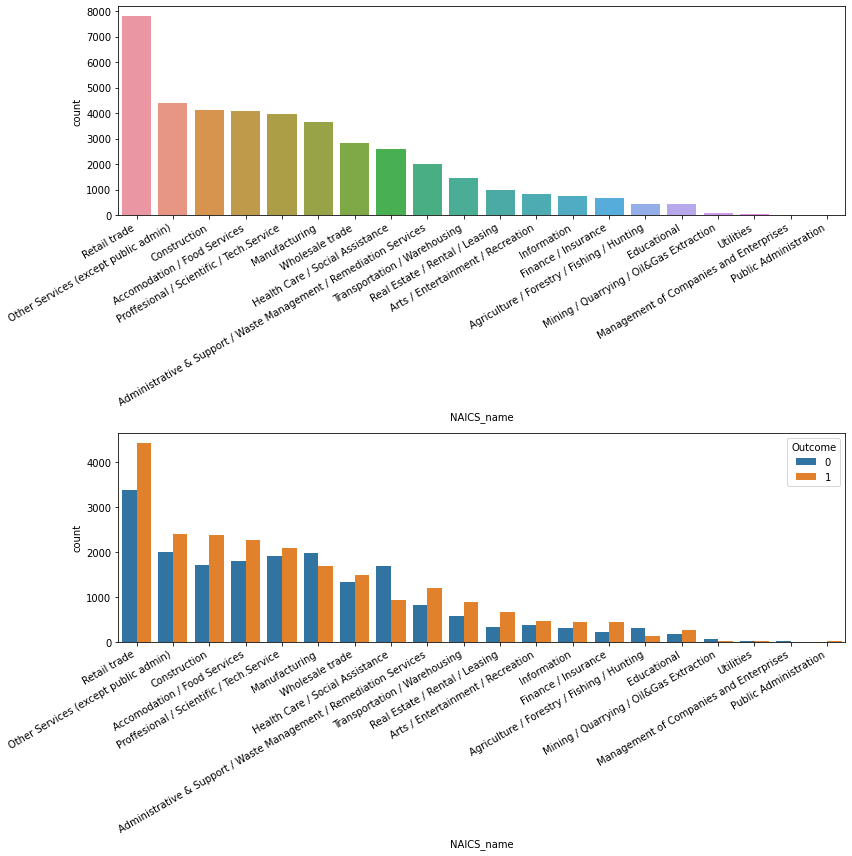

In [6]:
# distribution of NAICS
data["NAICS_name"] = data["NAICS"].astype(str).map({
    "11": "Agriculture / Forestry / Fishing / Hunting",
    "21": "Mining / Quarrying / Oil&Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "32": "Manufacturing",
    "33": "Manufacturing",
    "42": "Wholesale trade",
    "44": "Retail trade",
    "45": "Retail trade",
    "48": "Transportation / Warehousing",
    "49": "Transportation / Warehousing",
    "51": "Information",
    "52": "Finance / Insurance",
    "53": "Real Estate / Rental / Leasing",
    "54": "Proffesional / Scientific / Tech.Service",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative & Support / Waste Management / Remediation Services",
    "61": "Educational",
    "62": "Health Care / Social Assistance",
    "71": "Arts / Entertainment / Recreation",
    "72": "Accomodation / Food Services",
    "81": "Other Services (except public admin)",
    "92": "Public Administration"
})

test["NAICS_name"] = test["NAICS"].astype(str).map({
    "11": "Agriculture / Forestry / Fishing / Hunting",
    "21": "Mining / Quarrying / Oil&Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "32": "Manufacturing",
    "33": "Manufacturing",
    "42": "Wholesale trade",
    "44": "Retail trade",
    "45": "Retail trade",
    "48": "Transportation / Warehousing",
    "49": "Transportation / Warehousing",
    "51": "Information",
    "52": "Finance / Insurance",
    "53": "Real Estate / Rental / Leasing",
    "54": "Proffesional / Scientific / Tech.Service",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative & Support / Waste Management / Remediation Services",
    "61": "Educational",
    "62": "Health Care / Social Assistance",
    "71": "Arts / Entertainment / Recreation",
    "72": "Accomodation / Food Services",
    "81": "Other Services (except public admin)",
    "92": "Public Administration"
})

order = data["NAICS_name"].value_counts().index
plt.figure(figsize = (12,12))

plt.subplot(2,1,1)
sns.countplot(data = data, x = "NAICS_name", order = order)
plt.xticks(rotation = 30, ha = "right")

plt.subplot(2,1,2)
sns.countplot(data = data, x = "NAICS_name", hue = "Outcome", order = order)
plt.xticks(rotation = 30, ha = "right")

plt.tight_layout()
plt.savefig("NAICS.png")

### ApprovalFY

In [7]:
# preprocessing
# data["ApprovalFY"].unique()
data["ApprovalFY"] = data["ApprovalFY"].replace("1976A", "1976", regex = True).astype(int)
test["ApprovalFY"] = test["ApprovalFY"].replace("1976A", "1976", regex = True).astype(int)
data.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Outcome,NAICS_sector_rate,NAICS_name
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,33,16-Apr-10,2010,130,25,1.0,2,0,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00",0,0.14,Manufacturing
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,23,30-Jan-10,2010,33,6,1.0,1,3,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00",1,0.23,Construction
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,81,29-Jul-02,2002,60,1,1.0,1,1,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00",0,0.20,Other Services (except public admin)
3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,160,1,2.0,0,0,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00",0,NaN,NaN
4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,62,6-Feb-06,2006,101,2,1.0,7,2,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00",0,0.10,Health Care / Social Assistance


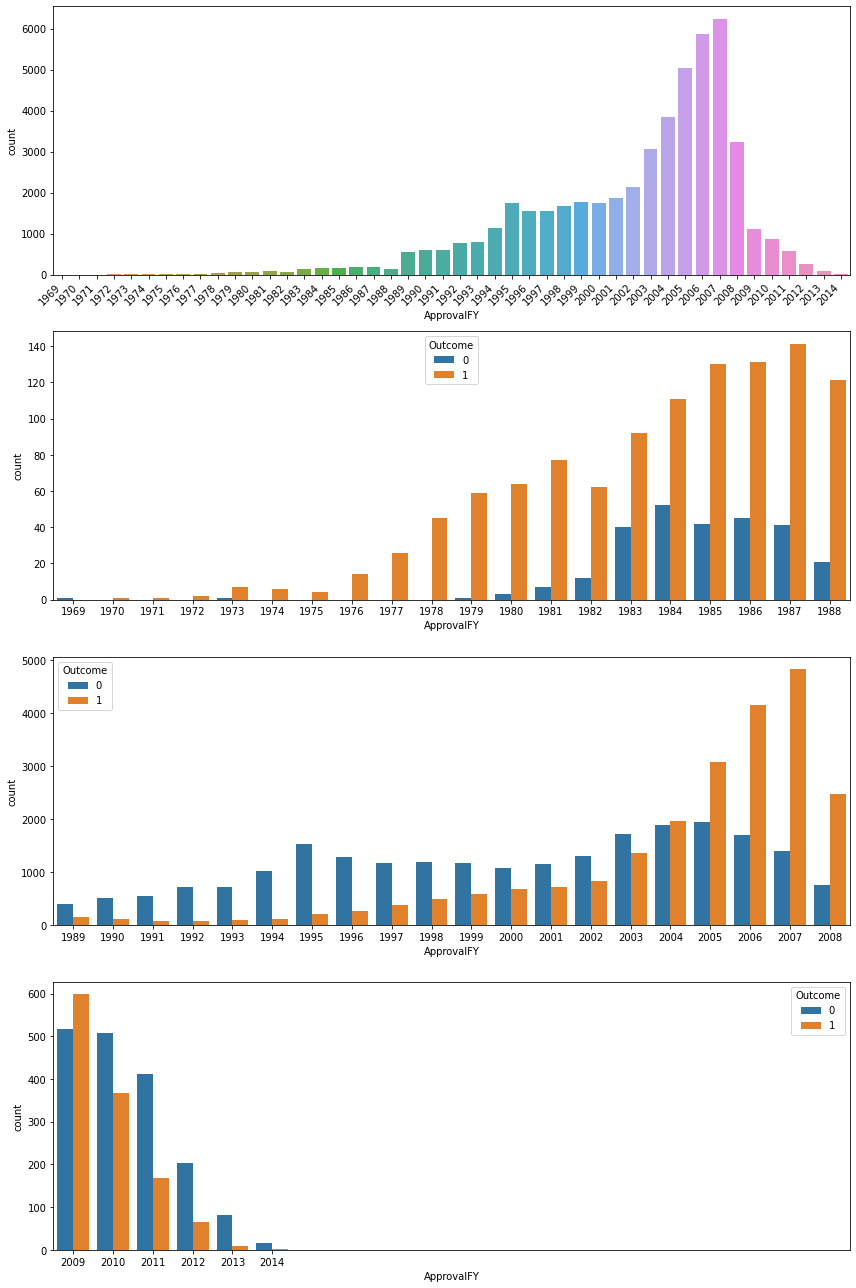

In [8]:
# distribution of ApprovalFY
plt.figure(figsize = (12,18))
plt.subplot(4,1,1)
sns.countplot(data = data, x = "ApprovalFY")
plt.xticks(rotation = 45, ha = "right")

plt.subplot(4,1,2)
sns.countplot(data = data[((data["ApprovalFY"] >= 1969) & (data["ApprovalFY"] < 1989))], x = "ApprovalFY", hue = "Outcome")
plt.xlim(-0.5, 19.5)

plt.subplot(4,1,3)
sns.countplot(data = data[((data["ApprovalFY"] >= 1989) & (data["ApprovalFY"] < 2009))], x = "ApprovalFY", hue = "Outcome")
plt.xlim(-0.5, 19.5)

plt.subplot(4,1,4)
sns.countplot(data = data[data["ApprovalFY"] >= 2009], x = "ApprovalFY", hue = "Outcome")
plt.xlim(-0.5, 19.5)

plt.tight_layout()
plt.savefig("ApprovalFY.png")

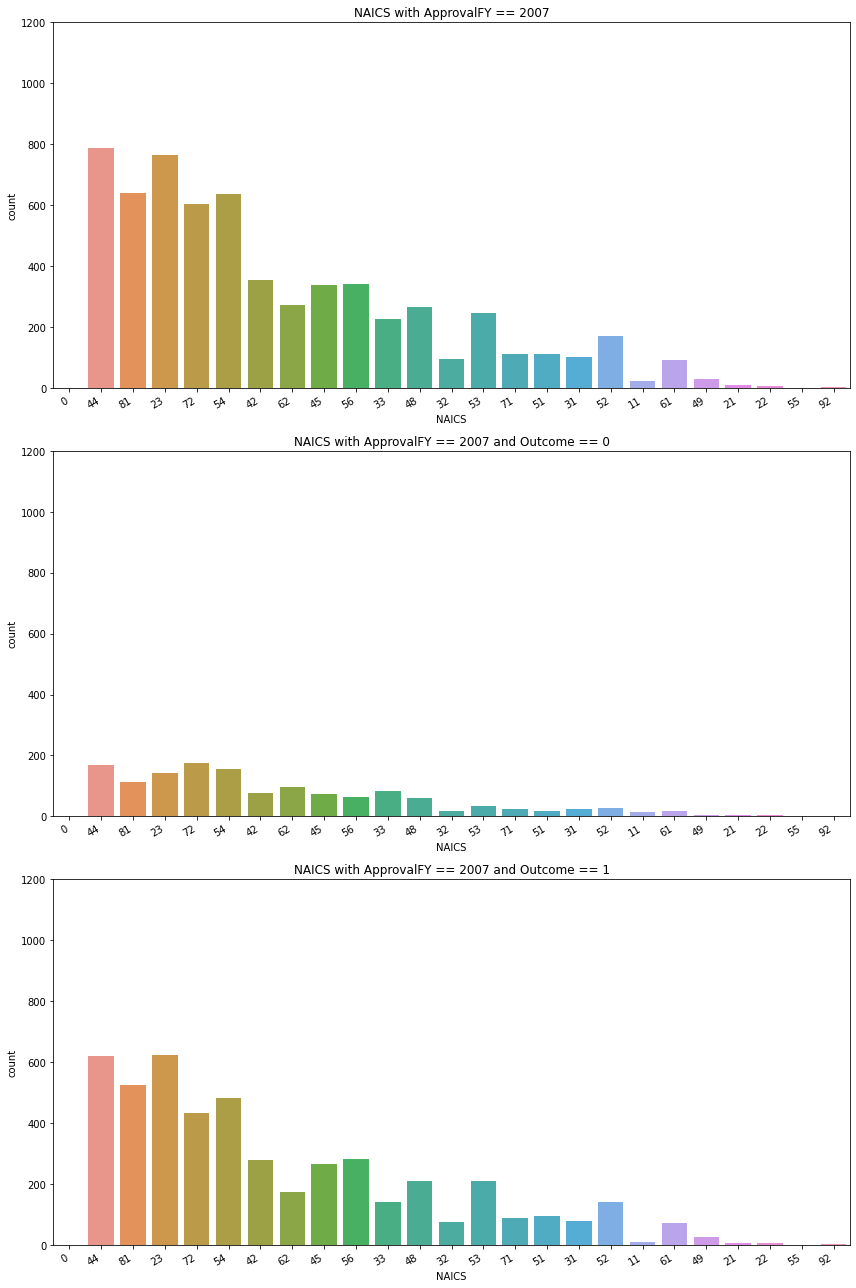

In [9]:
# distribution of NAICS corresponding to ApprovalFY
order = data["NAICS"].value_counts().index

plt.figure(figsize = (12,18))

plt.subplot(3,1,1)
sns.countplot(data = data[data["ApprovalFY"] == 2007], x = "NAICS", order = order)
plt.title("NAICS with ApprovalFY == 2007")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 1200)

plt.subplot(3,1,2)
sns.countplot(data = data[((data["ApprovalFY"] == 2007) & (data["Outcome"] == 0))], x = "NAICS", order = order)
plt.title("NAICS with ApprovalFY == 2007 and Outcome == 0")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 1200)

plt.subplot(3,1,3)
sns.countplot(data = data[((data["ApprovalFY"] == 2007) & (data["Outcome"] == 1))], x = "NAICS", order = order)
plt.title("NAICS with ApprovalFY == 2007 and Outcome == 1")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 1200)

plt.tight_layout()

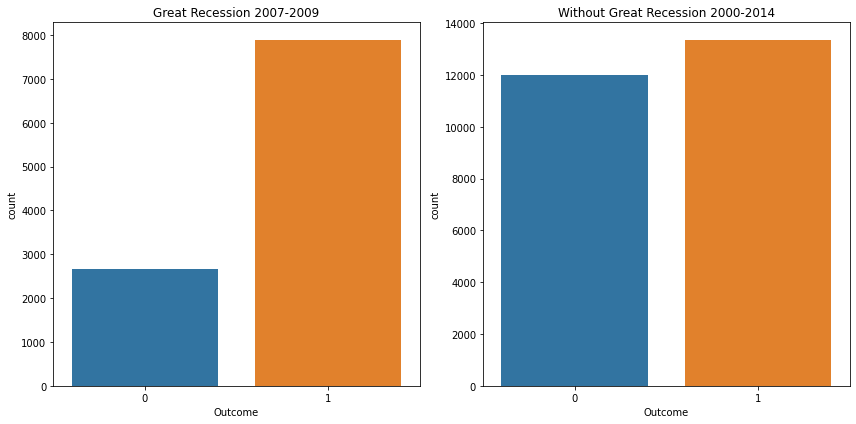

In [10]:
# distribution of ApprovalFY with and without Great Recession
data_0014 = data[(~((data["ApprovalFY"] >= 2007) & (data["ApprovalFY"] <= 2009)) & (data["ApprovalFY"] >= 2000))]
data_0709 = data[(  (data["ApprovalFY"] >= 2007) & (data["ApprovalFY"] <= 2009))]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data_0709["Outcome"])
plt.title('Great Recession 2007-2009')

plt.subplot(1,2,2)
sns.countplot(data_0014["Outcome"])
plt.title('Without Great Recession 2000-2014')

plt.tight_layout()

data["Recession"] = data["ApprovalFY"].apply(lambda x: 1 if 2007 <= x <= 2009 else 0)
test["Recession"] = test["ApprovalFY"].apply(lambda x: 1 if 2007 <= x <= 2009 else 0)
# plt.savefig("Recession.png")

### Term

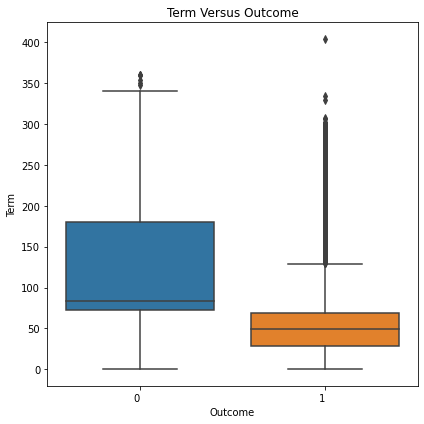

In [11]:
# distribution of Term corresponding to Outcome
plt.figure(figsize = (6,6))

sns.boxplot(data = data, x = "Outcome", y = "Term")
plt.title("Term Versus Outcome")
plt.xticks(ha = "right")

plt.tight_layout()
# plt.savefig("Term.png")

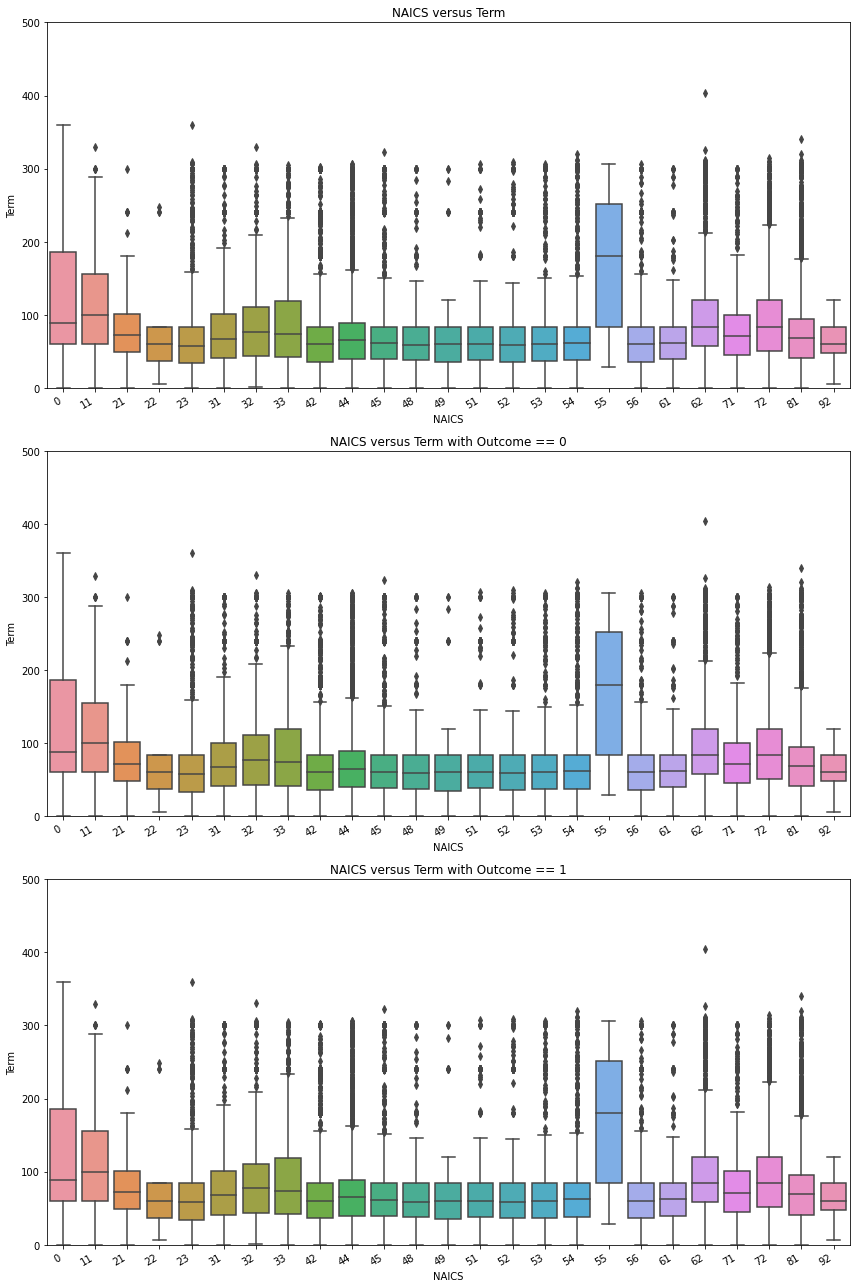

In [12]:
# distribution of NAICS corresponding to Term
order = data["NAICS"].value_counts().index

plt.figure(figsize = (12,18))

plt.subplot(3,1,1)
sns.boxplot(data = data, x = "NAICS", y = "Term")
plt.title("NAICS versus Term")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 500)

plt.subplot(3,1,2)
sns.boxplot(data = data, x = "NAICS", y = "Term")
plt.title("NAICS versus Term with Outcome == 0")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 500)

plt.subplot(3,1,3)
sns.boxplot(data = data, x = "NAICS", y = "Term")
plt.title("NAICS versus Term with Outcome == 1")
plt.xticks(rotation = 30, ha = "right")
plt.ylim(0, 500)

plt.tight_layout()

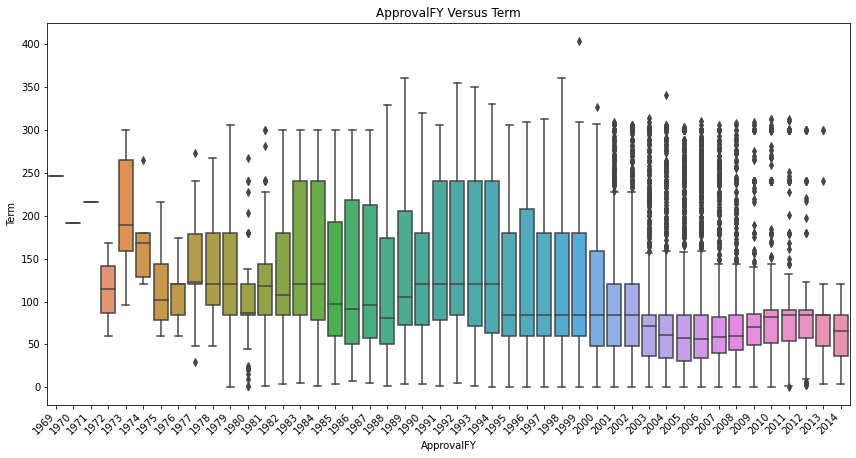

In [13]:
# distribution of ApprovalFy corresponding to Term
plt.figure(figsize = (12,18))

plt.subplot(3,1,1)
sns.boxplot(data = data, x = "ApprovalFY", y = "Term")
plt.title("ApprovalFY Versus Term")
plt.xticks(rotation = 45, ha = "right")

plt.tight_layout()

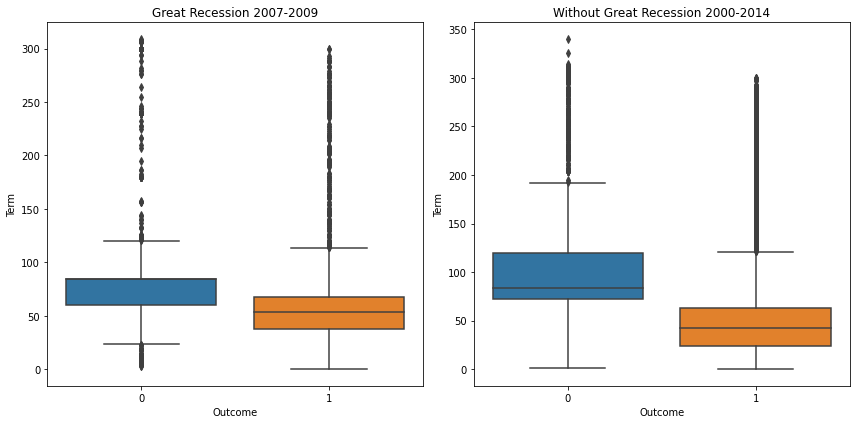

In [14]:
# distribution of Term with and without Great Recession
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.boxplot(data = data_0709, x = "Outcome", y = "Term")
plt.title('Great Recession 2007-2009')

plt.subplot(1,2,2)
sns.boxplot(data = data_0014, x = "Outcome", y = "Term")
plt.title('Without Great Recession 2000-2014')

plt.tight_layout()

### NewExist

In [15]:
# preprocessing
# or replace with median, or remain 0
# data["NewExist"] = data["NewExist"].replace({0: np.nan})
data["NewExist"] = data["NewExist"].replace({1.0: 0})
data["NewExist"] = data["NewExist"].replace({2.0: 1})
data.head()

test["NewExist"] = test["NewExist"].replace({1.0: 0})
test["NewExist"] = test["NewExist"].replace({2.0: 1})

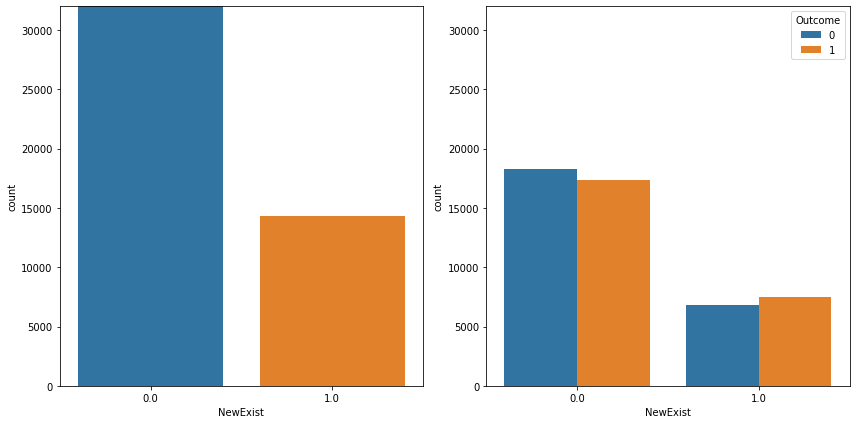

In [16]:
# distribution of NewExist
# plt.figure(figsize=(12,5))
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data, x = "NewExist")
plt.ylim(0, 32000)

plt.subplot(1,2,2)
sns.countplot(data = data, x = "NewExist", hue = "Outcome")
plt.ylim(0, 32000)

plt.tight_layout()
# plt.savefig("NewExist.png")

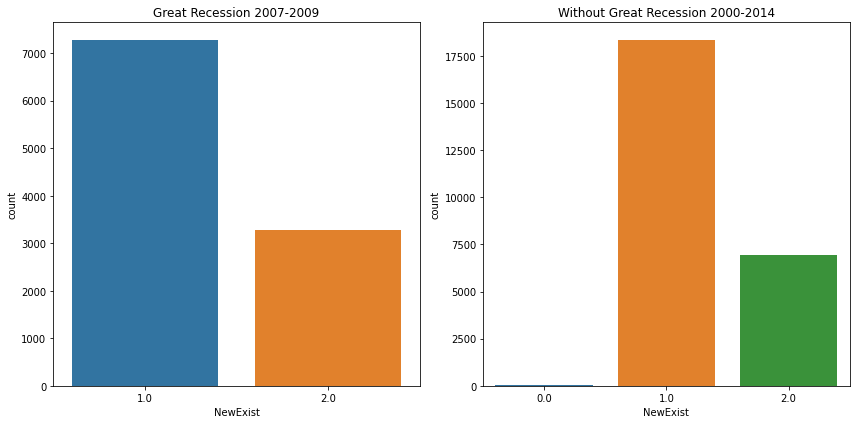

In [17]:
# distribution of NewExist with and without Great Recession
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data_0709, x = "NewExist")
plt.title('Great Recession 2007-2009')

plt.subplot(1,2,2)
sns.countplot(data = data_0014, x = "NewExist")
plt.title('Without Great Recession 2000-2014')

plt.tight_layout()

### FranchiseCode

In [18]:
# preprocessing
data['FranchiseCode'] = data['FranchiseCode'].replace({1: 0})
data['FranchiseCode'] = np.where((data.FranchiseCode != 0), 1, data.FranchiseCode)
data.head()

test['FranchiseCode'] = test['FranchiseCode'].replace({1: 0})
test['FranchiseCode'] = np.where((test.FranchiseCode != 0), 1, test.FranchiseCode)

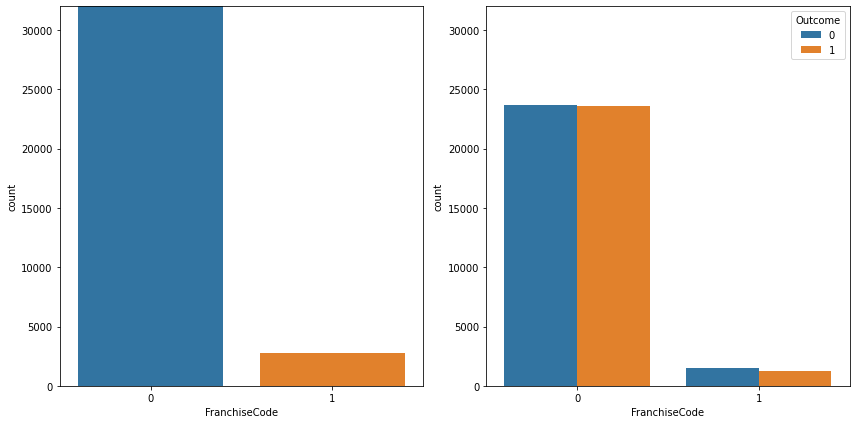

In [19]:
# distribution of FranchiseCode
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data, x = "FranchiseCode")
plt.ylim(0, 32000)

plt.subplot(1,2,2)
sns.countplot(data = data, x = "FranchiseCode", hue = "Outcome")
plt.ylim(0, 32000)

plt.tight_layout()
# plt.savefig("FranchiseCode.png")

### UrbanRural

In [20]:
# preprocessing
# or replace with median 
#data["UrbanRural"].value_counts()
# data["UrbanRural"] = data["UrbanRural"].replace({0: np.nan})
data["UrbanRural"] = data["UrbanRural"].replace({1: 0})
data["UrbanRural"] = data["UrbanRural"].replace({2: 1})
data["UrbanRural"] = np.where((data["UrbanRural"] != 0) & (data["UrbanRural"] != 1), np.nan, data["UrbanRural"])
data.head()

test["UrbanRural"] = test["UrbanRural"].replace({1: 0})
test["UrbanRural"] = test["UrbanRural"].replace({2: 1})
test["UrbanRural"] = np.where((test["UrbanRural"] != 0) & (test["UrbanRural"] != 1), np.nan, test["UrbanRural"])

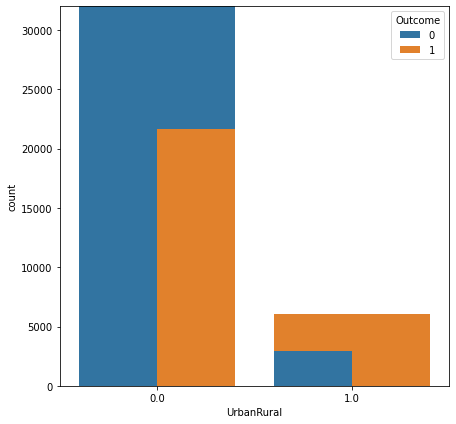

In [21]:
# distribution of UrbanRural
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data, x = "UrbanRural")
plt.ylim(0, 32000)

# plt.subplot(1,2,2)
sns.countplot(data = data, x = "UrbanRural", hue = "Outcome")
plt.ylim(0, 32000)

plt.tight_layout()
# plt.savefig("UrbanRural.png")

### RevLineCr

In [22]:
# preprocessing
# or replace with median or replace with 0 
# data["RevLineCr"].value_counts()
data["RevLineCr"] = data["RevLineCr"].replace({"0": 0, "1":1})
data["RevLineCr"] = data["RevLineCr"].replace({"N": 0, "Y":1})
data["RevLineCr"] = np.where((data["RevLineCr"] != 0) & (data["RevLineCr"] != 1), np.nan, data["RevLineCr"]).astype(float)
data.head()

test["RevLineCr"] = test["RevLineCr"].replace({"0": 0, "1":1})
test["RevLineCr"] = test["RevLineCr"].replace({"N": 0, "Y":1})
test["RevLineCr"] = np.where((test["RevLineCr"] != 0) & (test["RevLineCr"] != 1), np.nan, test["RevLineCr"]).astype(float)

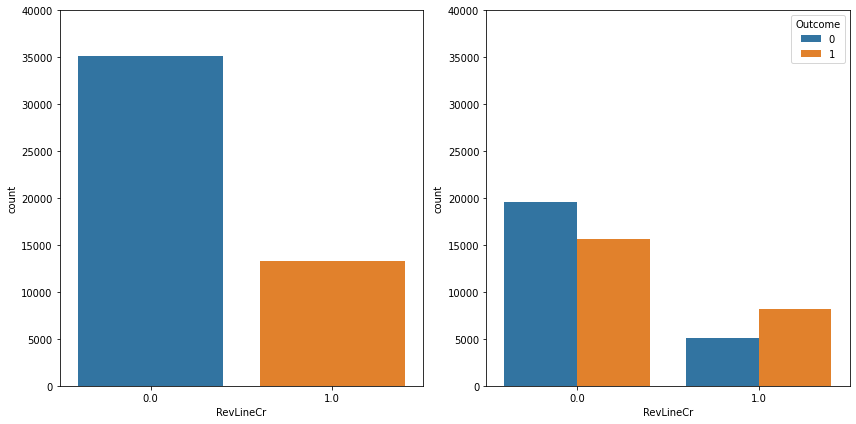

In [23]:
# distribution of RevLineCr
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data, x = "RevLineCr")
plt.ylim(0, 40000)

plt.subplot(1,2,2)
sns.countplot(data = data, x = "RevLineCr", hue = "Outcome")
plt.ylim(0, 40000)

plt.tight_layout()

### LowDoc

In [24]:
# preprocessing
# data["LowDoc"].value_counts()
data["LowDoc"] = data["LowDoc"].replace({"[C, S, A, R, 0, 1]": np.nan})
data["LowDoc"] = data["LowDoc"].replace({"N": 0, "Y": 1})
data["LowDoc"] = np.where((data["LowDoc"] != 0) & (data["LowDoc"] != 1), np.nan, data["LowDoc"]).astype(float)
data.head()

test["LowDoc"] = test["LowDoc"].replace({"[C, S, A, R, 0, 1]": np.nan})
test["LowDoc"] = test["LowDoc"].replace({"N": 0, "Y": 1})
test["LowDoc"] = np.where((test["LowDoc"] != 0) & (test["LowDoc"] != 1), np.nan, test["LowDoc"]).astype(float)

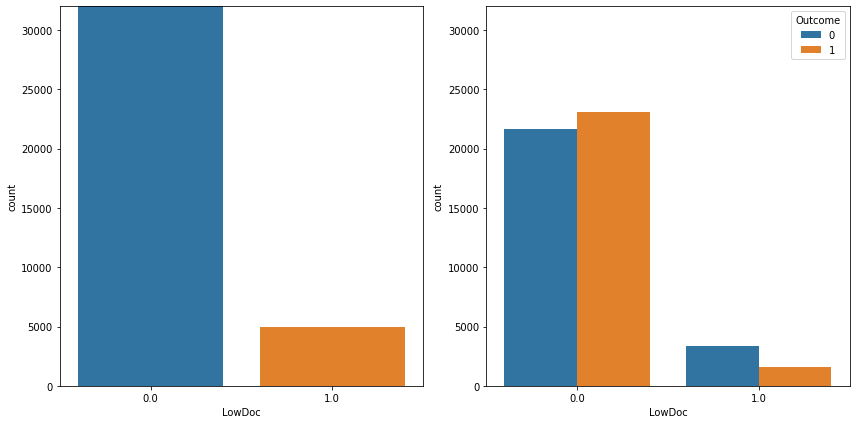

In [25]:
# distribution of LowDocs
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(data = data, x = "LowDoc")
plt.ylim(0, 32000)

plt.subplot(1,2,2)
sns.countplot(data = data, x = "LowDoc", hue = "Outcome")
plt.ylim(0, 32000)

plt.tight_layout()
plt.savefig("LowDoc.png")

### DisbursementGross, GrAppv and SBA_Appv

In [26]:
# preprocessing
# can focus more on where DisbursementGross == GrAppv
# data["DisbursementGross"].value_counts()
# data["GrAppv"].value_counts()
# data["SBA_Appv"].value_counts()
data["DisbursementGross"] = data["DisbursementGross"].replace("[\$,]", "", regex = True).astype(float)
data["GrAppv"  ] = data["GrAppv"  ].replace("[\$,]", "", regex = True).astype(float) 
data["SBA_Appv"] = data["SBA_Appv"].replace("[\$,]", "", regex = True).astype(float) 
data.head()

test["DisbursementGross"] = test["DisbursementGross"].replace("[\$,]", "", regex = True).astype(float)
test["GrAppv"  ] = test["GrAppv"  ].replace("[\$,]", "", regex = True).astype(float) 
test["SBA_Appv"] = test["SBA_Appv"].replace("[\$,]", "", regex = True).astype(float) 

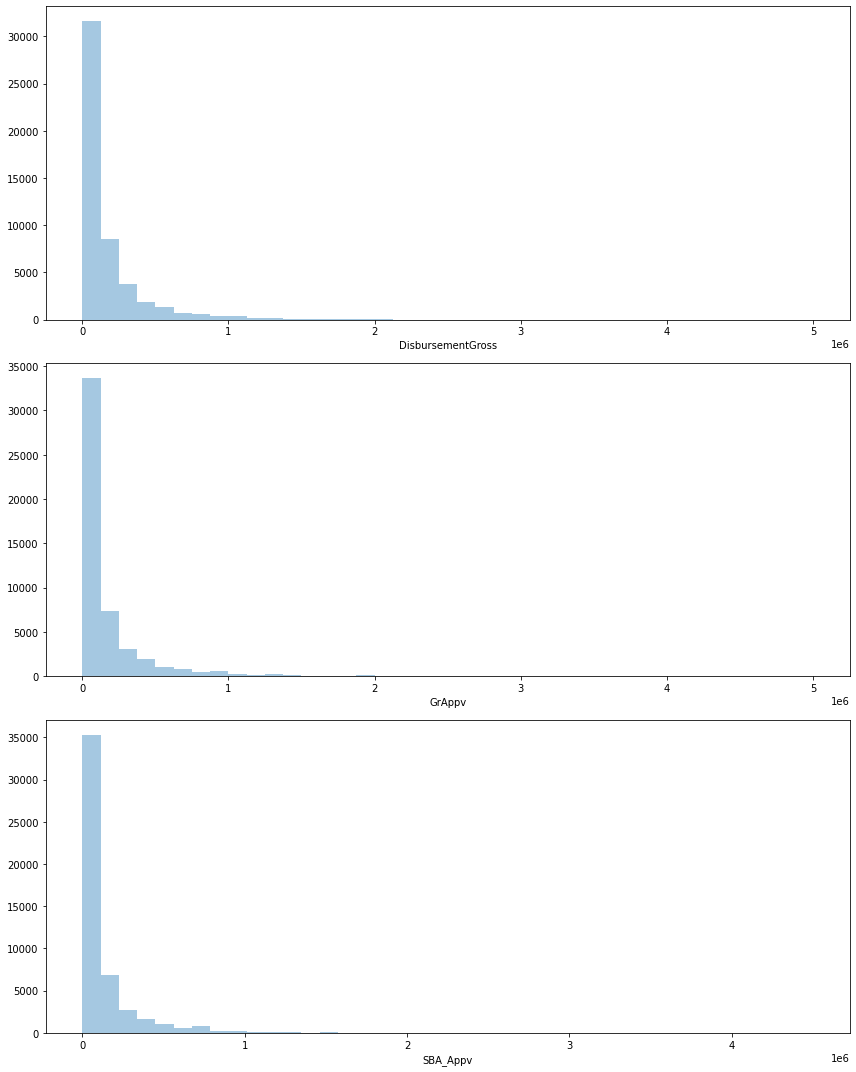

In [27]:
# distribution of DisbursementGross, GrAppv and SBA_Appv
plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
sns.distplot(data["DisbursementGross"], bins = 40, kde = False)

plt.subplot(3,1,2)
sns.distplot(data["GrAppv"]  , bins = 40, kde = False)

plt.subplot(3,1,3)
sns.distplot(data["SBA_Appv"], bins = 40, kde = False)

plt.tight_layout()

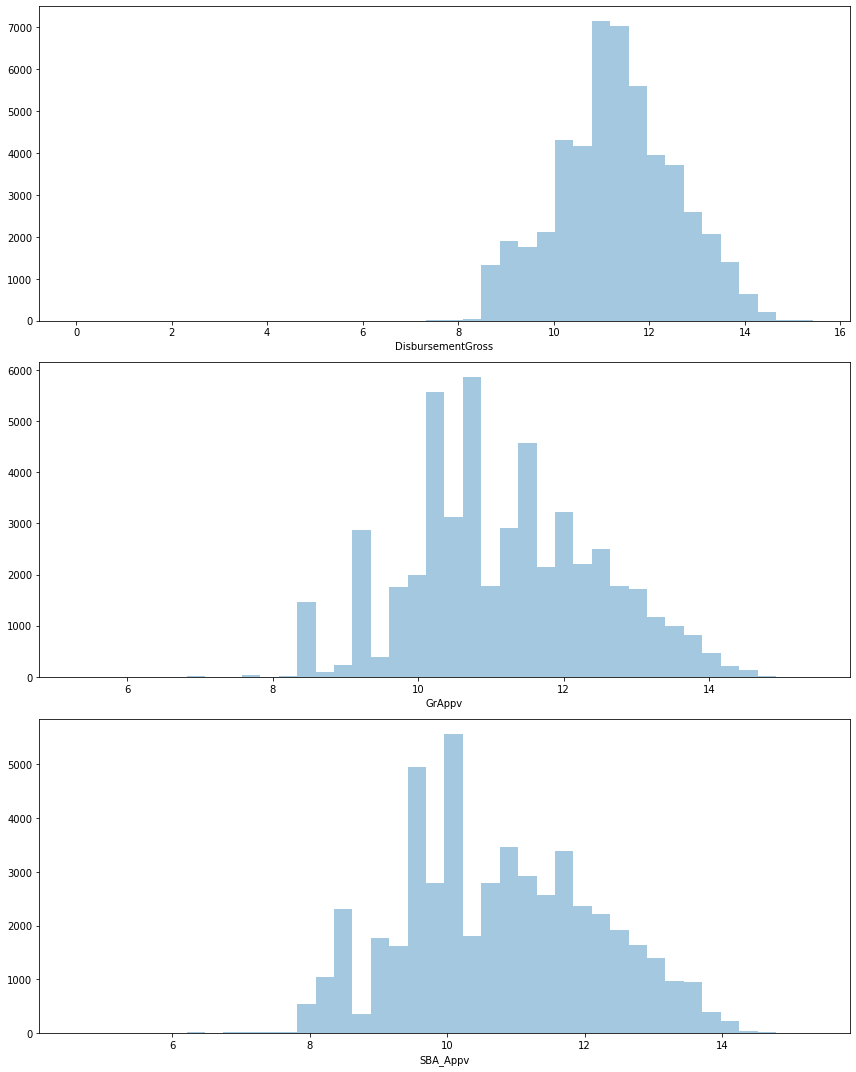

In [28]:
# distribution of logarithm of DisbursementGross, GrAppv and SBA_Appv
data["DisbursementGross"] = np.log(data["DisbursementGross"])
data["GrAppv"]   = np.log(data["GrAppv"])
data["SBA_Appv"] = np.log(data["SBA_Appv"])

data = data[(data["DisbursementGross"] >= -10)]
data = data[(data["GrAppv"]   >= -10)]
data = data[(data["SBA_Appv"] >= -10)]

plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
sns.distplot(data["DisbursementGross"], bins = 40, kde = False)

plt.subplot(3,1,2)
sns.distplot(data["GrAppv"]  , bins = 40, kde = False)

plt.subplot(3,1,3)
sns.distplot(data["SBA_Appv"], bins = 40, kde = False)

plt.tight_layout()

In [29]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "PR"]

data["State"]     = data["State"].    apply(lambda x : states.index(x) if not pd.isnull(x) else x)
data["BankState"] = data["BankState"].apply(lambda x : states.index(x) if not pd.isnull(x) else x)

data["ApprovalDate"] = pd.to_datetime(data["ApprovalDate"],format="%d-%b-%y", errors="coerce")
data["ApprovalDate"] = data["ApprovalDate"].apply(lambda x : pd.Timestamp(0, unit="s") if pd.isnull(x) else x)
data["ApprovalDate"] = data["ApprovalDate"].astype(int)/(10**11)

data["DisbursementDate"] = pd.to_datetime(data["DisbursementDate"],format="%d-%b-%y", errors="coerce")
data["DisbursementDate"] = data["DisbursementDate"].apply(lambda x : pd.Timestamp(0, unit="s") if pd.isnull(x) else x)
data["DisbursementDate"] = data["DisbursementDate"].astype(int)/(10**11)

data.head()

test["State"]     = test["State"].    apply(lambda x : states.index(x) if not pd.isnull(x) else x)
test["BankState"] = test["BankState"].apply(lambda x : states.index(x) if not pd.isnull(x) else x)

test["ApprovalDate"] = pd.to_datetime(data["ApprovalDate"],format="%d-%b-%y", errors="coerce")
test["ApprovalDate"] = test["ApprovalDate"].apply(lambda x : pd.Timestamp(0, unit="s") if pd.isnull(x) else x)
test["ApprovalDate"] = test["ApprovalDate"].astype(int)/(10**11)

test["DisbursementDate"] = pd.to_datetime(test["DisbursementDate"],format="%d-%b-%y", errors="coerce")
test["DisbursementDate"] = test["DisbursementDate"].apply(lambda x : pd.Timestamp(0, unit="s") if pd.isnull(x) else x)
test["DisbursementDate"] = test["DisbursementDate"].astype(int)/(10**11)

test.head()

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,NAICS_sector_rate,NAICS_name,Recession
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Bayridge Grocery Inc.,BROOKLYN,32.0,11209,BANK OF AMERICA NATL ASSOC,33.0,44,0.0,2006,47,6,0.0,0,6,0,0.0,1.0,0.0,11359872.0,120000.0,$0.00,100000.0,50000.0,0.22,Retail trade,0
1,SUBWAY,GILBERT,2.0,85297,INDEPENDENCE BANK,39.0,72,0.0,2003,120,10,1.0,0,0,1,0.0,0.0,1.0,10569312.0,130000.0,$0.00,130000.0,110500.0,0.22,Accomodation / Food Services,0
2,1-800 RADIATOR OF KATY,KATY,43.0,77450,BANCO POPULAR NORTH AMERICA,32.0,42,0.0,2007,98,1,1.0,1,1,1,0.0,0.0,0.0,11675232.0,184000.0,$0.00,184000.0,138000.0,0.19,Wholesale trade,1
3,"DAUGHTERY'S FOOD&FUEL CTR, INC",JEFFERSONVILLE,17.0,40337,"COMMUNITY TRUST BANK, INC.",17.0,44,0.0,2001,120,5,0.0,0,0,0,0.0,0.0,0.0,9885888.0,80000.0,$0.00,135000.0,101250.0,0.22,Retail trade,0
4,"TGGP ENTERPRISES, LLC",TWINSBURG,35.0,44087,CAPITAL ONE NATL ASSOC,46.0,72,0.0,2006,11,9,0.0,1,9,0,0.0,0.0,0.0,11359872.0,50000.0,$0.00,50000.0,25000.0,0.22,Accomodation / Food Services,0


In [30]:
# save the preprocessed data
delete = ["Name", "City", "Bank", "BalanceGross", "NAICS_name"]
data = data.drop(delete, axis = 1)
test = test.drop(delete, axis = 1)

data.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49993 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              49993 non-null  int64  
 1   Zip                49993 non-null  int64  
 2   BankState          49921 non-null  float64
 3   NAICS              49993 non-null  int64  
 4   ApprovalDate       49993 non-null  float64
 5   ApprovalFY         49993 non-null  int64  
 6   Term               49993 non-null  int64  
 7   NoEmp              49993 non-null  int64  
 8   NewExist           49986 non-null  float64
 9   CreateJob          49993 non-null  int64  
 10  RetainedJob        49993 non-null  int64  
 11  FranchiseCode      49993 non-null  int64  
 12  UrbanRural         49993 non-null  float64
 13  RevLineCr          48466 non-null  float64
 14  LowDoc             49641 non-null  float64
 15  DisbursementDate   49993 non-null  float64
 16  DisbursementGross  499

## Feature selection
delete features have low correlation with outcome.

In [31]:
# the delete dictionary list
delete = {}

In [32]:
### whole data
order = data.columns.tolist()
order.remove("Outcome")
order.append("Outcome")
data = data[order]

# plt.figure(figsize = (20,20))
# sns.heatmap(data.corr(), annot = True, cmap = "Spectral")

delete1 = ["Zip", "BankState", "CreateJob", "RetainedJob"]
delete2 = ["FranchiseCode", "UrbanRural"]
delete3 = ["State", "NoEmp", "NewExist"]

final_1 = data.copy()
final_1 = final_1.drop(delete1, axis = 1)

final_2 = final_1.copy()
final_2 = final_2.drop(delete2, axis = 1)

final_3 = final_2.copy()
final_3 = final_3.drop(delete3, axis = 1)

# print ("Unique Values in each columns")
# for k in final_1.columns:
#     print("{:20} {}".format(k, len(final_1[k].unique())))

# plt.figure(figsize = (20,20))
# sns.heatmap(final_1.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_2.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_3.corr(), annot = True, cmap = "Spectral")

delete[("whole", 1)] = delete1
delete[("whole", 2)] = delete2
delete[("whole", 3)] = delete3

In [33]:
### data with recession
data_0709 = data[(data["Recession"] == 1)]
order = data.columns.tolist()
order.remove("Outcome")
order.remove("Recession")
order.append("Outcome")
data_0709 = data_0709[order]

# plt.figure(figsize = (20,20))
# sns.heatmap(data_0709.corr(), annot = True, cmap = "Spectral")

delete1 = ["NAICS", "LowDoc"]
delete2 = ["Zip", "NewExist", "CreateJob", "FranchiseCode"]
delete3 = ["RevLineCr", "DisbursementDate"]

final_0709_1 = data_0709.copy()
final_0709_1 = final_0709_1.drop(delete1, axis = 1)

final_0709_2 = final_0709_1.copy()
final_0709_2 = final_0709_2.drop(delete2, axis = 1)

final_0709_3 = final_0709_2.copy()
final_0709_3 = final_0709_3.drop(delete3, axis = 1)

# print ("Unique Values in each columns")
# for k in final_0709_1.columns:
#     print("{:20} {}".format(k, len(final_0709_1[k].unique())))
    
# plt.figure(figsize = (20,20))
# sns.heatmap(final_0709_1.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_0709_2.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_0709_3.corr(), annot = True, cmap = "Spectral")

delete[("recession", 1)] = delete1
delete[("recession", 2)] = delete2
delete[("recession", 3)] = delete3

In [34]:
### data without recession
data_0014 = data[(data["Recession"] == 0)]
order = data.columns.tolist()
order.remove("Outcome")
order.remove("Recession")
order.append("Outcome")

# plt.figure(figsize = (20,20))
# sns.heatmap(data_0014.corr(), annot = True, cmap = "Spectral")

delete1 = ["Zip", "NAICS"]
delete2 = ["State", "NewExist", "CreateJob", "RetainedJob", "FranchiseCode", "UrbanRural"]
delete3 = ["BankState", "RevLineCr", "LowDoc"]

final_0014_1 = data_0014.copy()
final_0014_1 = final_0014_1.drop(delete1, axis = 1)

final_0014_2 = final_0014_1.copy()
final_0014_2 = final_0014_2.drop(delete2, axis = 1)

final_0014_3 = final_0014_2.copy()
final_0014_3 = final_0014_3.drop(delete3, axis = 1)

# print ("Unique Values in each columns")
# for k in final_0014_1.columns:
#     print("{:20} {}".format(k, len(final_0014_1[k].unique())))

# plt.figure(figsize = (20,20))
# sns.heatmap(final_0014_1.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_0014_2.corr(), annot = True, cmap = "Spectral")

# plt.figure(figsize = (20,20))
# sns.heatmap(final_0014_3.corr(), annot = True, cmap = "Spectral")

delete[("nonerecession", 1)] = delete1
delete[("nonerecession", 2)] = delete2
delete[("nonerecession", 3)] = delete3

In [35]:
import pickle
with open("delete.pickle", "wb") as handle:
    pickle.dump(delete, handle, protocol = pickle.HIGHEST_PROTOCOL)
print ("[Done] Data analyzing!")

[Done] Data analyzing!


<AxesSubplot:>

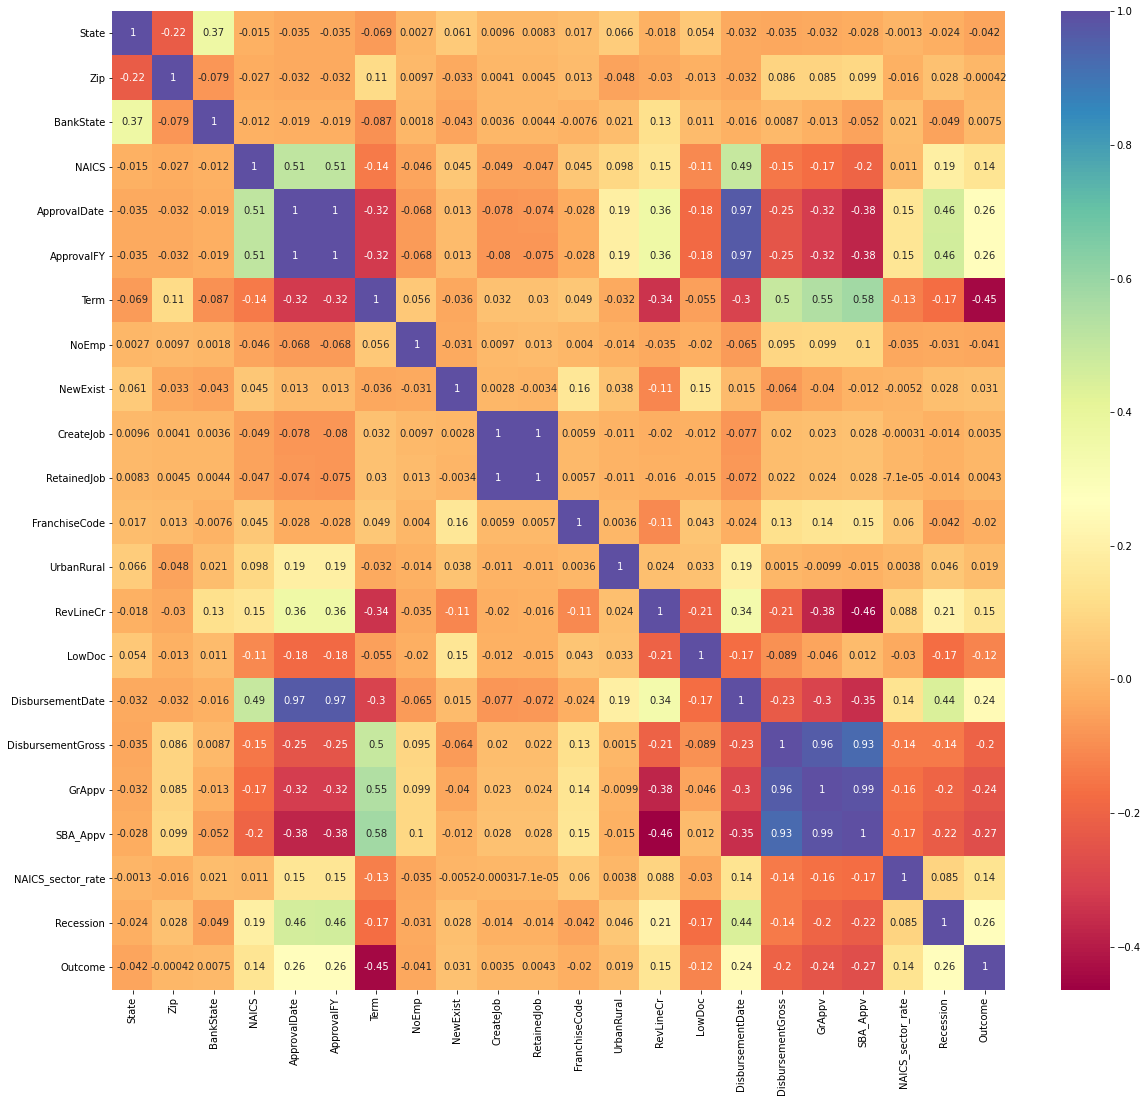

In [36]:
# plot correlation feature heat map
plt.figure(figsize = (20,18))
sns.heatmap(data.corr(), annot = True, cmap = "Spectral")

In [37]:
delete

{('whole', 1): ['Zip', 'BankState', 'CreateJob', 'RetainedJob'],
 ('whole', 2): ['FranchiseCode', 'UrbanRural'],
 ('whole', 3): ['State', 'NoEmp', 'NewExist'],
 ('recession', 1): ['NAICS', 'LowDoc'],
 ('recession', 2): ['Zip', 'NewExist', 'CreateJob', 'FranchiseCode'],
 ('recession', 3): ['RevLineCr', 'DisbursementDate'],
 ('nonerecession', 1): ['Zip', 'NAICS'],
 ('nonerecession', 2): ['State',
  'NewExist',
  'CreateJob',
  'RetainedJob',
  'FranchiseCode',
  'UrbanRural'],
 ('nonerecession', 3): ['BankState', 'RevLineCr', 'LowDoc']}